<a href="https://colab.research.google.com/github/Vipul-Jirge/My_Experiments_with_CV_DL/blob/main/Car_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.2
Found GPU at: /device:GPU:0


In [3]:
# Creating different folders for tf prep
curr_dir = r"/content/drive/MyDrive/Assignment_Uploads/Image_Recognition"
DIR_TRAIN_FOLDER = os.path.join(curr_dir, "./train/")
train_csv = pd.read_csv(os.path.join(curr_dir, "./train.csv"))

train_images:np.ndarray = train_csv["image_name"].values
train_labels:np.ndarray = train_csv["label"].values

import contextlib
train_prep_dir = os.path.join(curr_dir,'train_subs')
with contextlib.suppress(Exception):
  os.mkdir(train_prep_dir)

  for i in range(1,max(train_labels)+1):
      with contextlib.suppress(Exception):
          os.mkdir(os.path.join(train_prep_dir,str(i)))

  for i, jpgfile in enumerate(glob.iglob(os.path.join(DIR_TRAIN_FOLDER, "*.jpg"))):
      shutil.copy(jpgfile, os.path.join(train_prep_dir, str(train_labels[i])))


DIR_TEST_FOLDER = os.path.join(curr_dir, "./test/")
test_csv = pd.read_csv(os.path.join(curr_dir, "./test.csv"))

test_images:np.ndarray = test_csv["image_name"].values
test_labels:np.ndarray = test_csv["label"].values

test_prep_dir = os.path.join(curr_dir,'test_subs')
with contextlib.suppress(Exception):
  os.mkdir(test_prep_dir)

  for i in range(1,max(test_labels)+1):
      with contextlib.suppress(Exception):
          os.mkdir(os.path.join(test_prep_dir,str(i)))

  for i, jpgfile in enumerate(glob.iglob(os.path.join(DIR_TEST_FOLDER, "*.jpg"))):
      shutil.copy(jpgfile, os.path.join(test_prep_dir, str(train_labels[i])))


In [49]:
batch_size = 128
img_height = 160
img_width = 160

data_dir=os.path.join(curr_dir,'./train_subs/')

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

class_names = train_ds.class_names

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.
Number of validation batches: 11
Number of test batches: 2


Data Augmentation

In [50]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Preprocessing for TL - Mobilenetv2

In [51]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SIZE = (160, 160)

# Create the base model from the pre-trained model MobileNet V2 trained on imagenet DB
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = True
# base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


(128, 5, 5, 1280)
(128, 1280)
(128, 1)


Compile Model

In [52]:
base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

Train Model

In [55]:
initial_epochs = 35

loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 7s 146ms/step - loss: -45.4109 - accuracy: 0.0058
initial loss: -45.41
initial accuracy: 0.01


In [56]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/35
51/51 [==============================] - 38s 661ms/step - loss: -50.3671 - accuracy: 0.0038 - val_loss: -50.7428 - val_accuracy: 0.0066
Epoch 2/35
51/51 [==============================] - 39s 695ms/step - loss: -58.9113 - accuracy: 0.0046 - val_loss: -58.9318 - val_accuracy: 0.0051
Epoch 3/35
51/51 [==============================] - 39s 688ms/step - loss: -67.9365 - accuracy: 0.0048 - val_loss: -66.6671 - val_accuracy: 0.0058
Epoch 4/35
51/51 [==============================] - 38s 666ms/step - loss: -75.1374 - accuracy: 0.0046 - val_loss: -78.7224 - val_accuracy: 0.0051
Epoch 5/35
51/51 [==============================] - 39s 685ms/step - loss: -87.8433 - accuracy: 0.0055 - val_loss: -89.7135 - val_accuracy: 0.0051
Epoch 6/35
51/51 [==============================] - 38s 667ms/step - loss: -101.6423 - accuracy: 0.0046 - val_loss: -105.4715 - val_accuracy: 0.0058
Epoch 7/35
51/51 [==============================] - 39s 688ms/step - loss: -117.2417 - accuracy: 0.0049 - val_loss: 

Evaluation

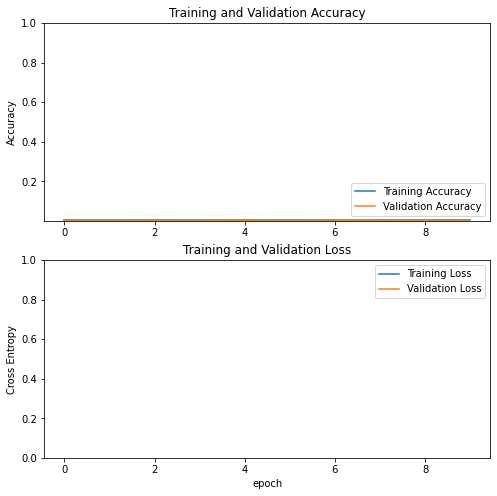

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers: # Yes for TL
    layer.trainable = False

x = Flatten()(inception.output)
prediction = Dense(len(train_labels), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)
model.summary()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(os.path.join(curr_dir,'./train_subs/'),
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(os.path.join(curr_dir,'./test_subs/'),
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8144 images belonging to 196 classes.
Found 403 images belonging to 196 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10)
#,
  # steps_per_epoch=len(training_set),
  # validation_steps=len(test_set))

Epoch 1/10


UnimplementedError: ignored

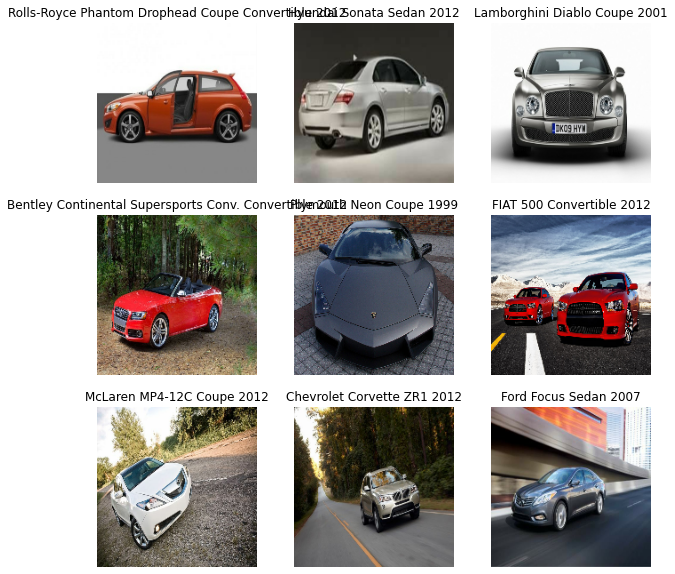

In [ ]:

import itertools
class_names = pd.read_csv(os.path.join(curr_dir,'./class_names.csv'))
col_name = class_names.columns[0]
class_names = class_names[col_name].tolist()
class_names.insert(0,col_name)

plt.figure(figsize=(10, 10))
for (images, labels), i in itertools.product(train_ds.take(1), range(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
102/102 [==============================] - 540s 4s/step - loss: 5.2814 - accuracy: 0.0054 - val_loss: 5.2790 - val_accuracy: 0.0074
Epoch 2/15
102/102 [==============================] - 224s 2s/step - loss: 5.2776 - accuracy: 0.0077 - val_loss: 5.2802 - val_accuracy: 0.0068
Epoch 3/15
102/102 [==============================] - 222s 2s/step - loss: 5.2750 - accuracy: 0.0086 - val_loss: 5.2857 - val_accuracy: 0.0080
Epoch 4/15
102/102 [==============================] - 225s 2s/step - loss: 5.2675 - accuracy: 0.0087 - val_loss: 5.2927 - val_accuracy: 0.0098
Epoch 5/15
102/102 [==============================] - 222s 2s/step - loss: 5.2584 - accuracy: 0.0103 - val_loss: 5.2951 - val_accuracy: 0.0086
Epoch 6/15
102/102 [==============================] - 226s 2s/step - loss: 5.2463 - accuracy: 0.0095 - val_loss: 5.3154 - val_accuracy: 0.0068
Epoch 7/15
102/102 [==============================] - 225s 2s/step - loss: 5.2356 - accuracy: 0.0107 - val_loss: 5.3553 - val_accuracy: 0.0061

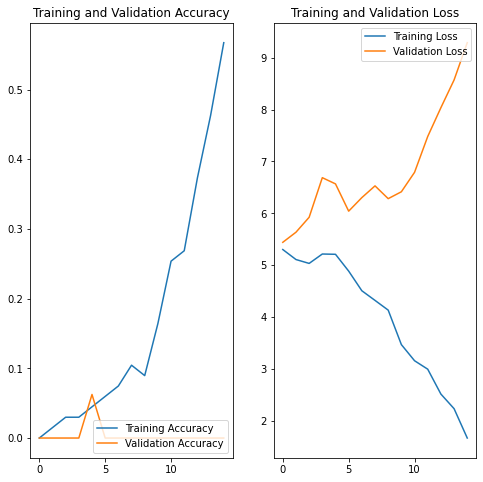

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()